# Predikcija čvrstoće betona
Predviđamo **pritisnu čvrstoću betona (MPa)** na osnovu sastava mešavine.
Dataset: 1030 uzoraka, 8 ulaznih obeležja (cement, voda, dodaci, starost...), 1 ciljna promenljiva.

## Istraživačka pitanja
1. **Q1** - Koji sastojci najviše utiču na čvrstoću? → Feature importance
2. **Q2** - Da li je linearna regresija dovoljna? → Poređenje OLS vs RF vs XGBoost
3. **Q3** - Koji sastav i starost daju najveću čvrstoću? → Top 10 predikcija XGBoost-a

In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "src")

from preprocessing import load_data, add_features, cap_outliers, split_data
from models import train_ols, tune_rf, tune_xgb
from evaluation import evaluate_model, comparison_table
from validation import validate_ols
from visualization import (
    print_data_overview,
    plot_boxplots,
    plot_boxplots_after,
    plot_age_vs_strength,
    plot_correlation_heatmap,
    plot_single_model_diagnostics,
    plot_feature_importance_single,
)

## Dataset

In [2]:
df = load_data()
df_feat = add_features(df)
print_data_overview(df)

PREGLED DATASETA

Oblik dataseta: (1030, 9) — 1030 redova i 9 kolona

Informacije o kolonama:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Osnovne statistike:
        Cement  Blast Furnace Slag  Fly Ash    Water  Superplasticizer  \
count  1030.00             1030.00  1030.00  1030.00           1030.00   
mean    281.17               73.90  

Dataset nema nedostajucih vrednosti. Postoji 25 duplikata (iste kombinacije sastojaka i starosti), ali ih zadrzavamo - realne su mešavine koje mogu imati iste parametre a razlicitu izmerenu čvrstoću usled varijacija u procesu.

## Eksploratorna analiza podataka

### Uticaj starosti betona na čvrstoću

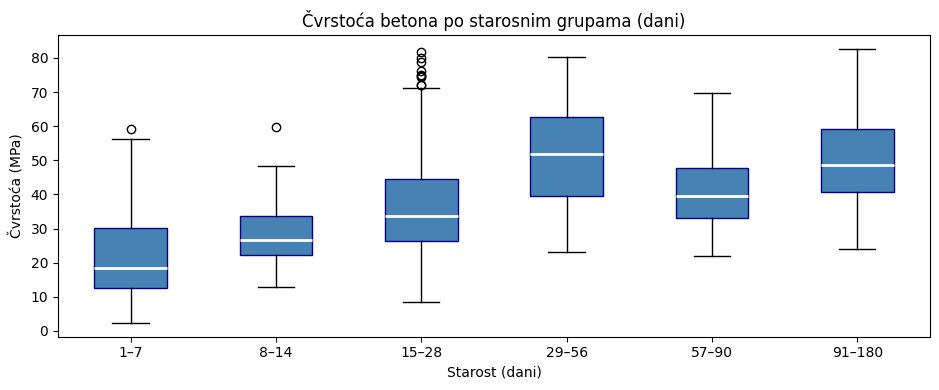

In [3]:
plot_age_vs_strength(df_feat)

Stariji beton je generalno čvršći- Age je jedan od najvažnijih prediktora. Posebno je važno primetiti da veza **nije linearna**: čvrstoća raste ubrzano do ~28 dana (standardni period negovanja betona), a zatim usporava i stabilizuje se. Ovakav nelinearni obrazac direktno ohrabruje primenu modela koji mogu da ga uhvate- Random Forest i XGBoost, za razliku od OLS-a koji pretpostavlja linearnu vezu.

### Korelaciona matrica

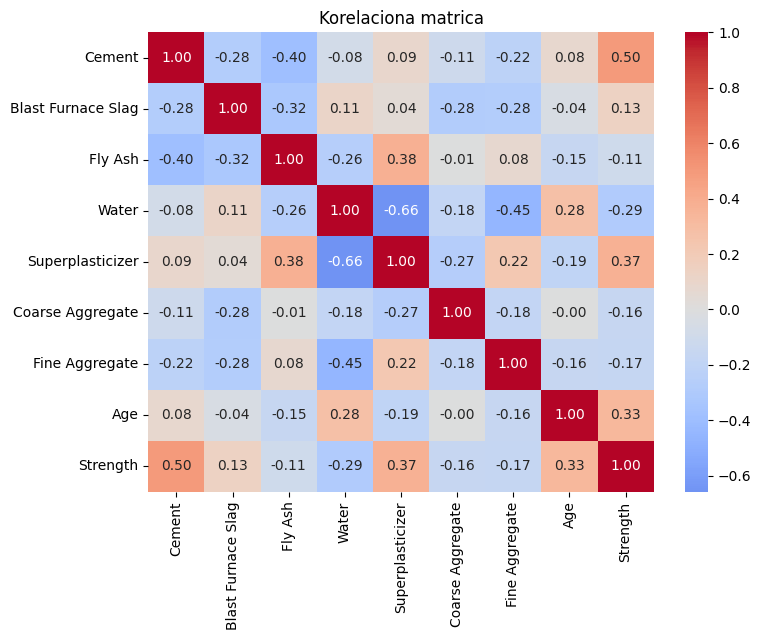

In [4]:
plot_correlation_heatmap(df_feat)

Cement (0.50) i Age (0.33) imaju najveću pozitivnu korelaciju sa čvrstoćom. Water ima negativnu korelaciju (-0.29) - u skladu sa Abrams-ovim zakonom (više vode -> manja čvrstoća).

Uočava se i **kolinearnost između prediktora** - npr. Blast Furnace Slag i Fly Ash su negativno korelisani sa Cement-om, što ima smisla jer se koriste kao delimična zamena za cement u mešavini. Ipak, **nijednu promenljivu ne možemo izbaciti**: sve su fizički sastojci betonske mešavine i svaka direktno utiče na njenu strukturu. Izbacivanje bilo koje od njih ne bi imalo smisla ni sa stanovišta domenskog znanja.

### Box plotovi obeležja (pre obrade)

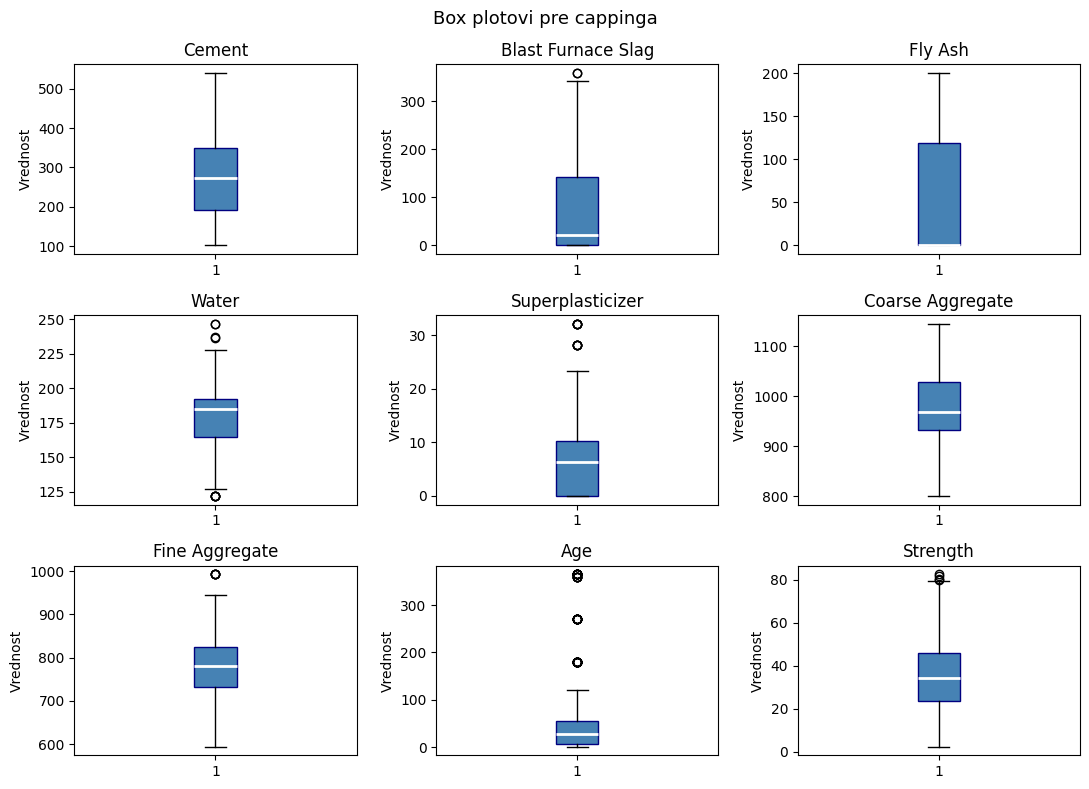

In [5]:
plot_boxplots(df_feat)

Uočavaju se outlieri, posebno kod Superplasticizer i Blast Furnace Slag -> motivisaće capping u narednom koraku preprocessinga radi poboljsanja OLS modela.

## Preprocessing

### Dodavanje feature-a: water_cement_ratio

In [6]:
df_feat[['Water', 'Cement', 'water_cement_ratio']].head(10)

,Water,Cement,water_cement_ratio
0,162.0,540.0,0.300000
1,162.0,540.0,0.300000
2,228.0,332.5,0.685714
3,228.0,332.5,0.685714
4,192.0,198.6,0.966767
5,228.0,266.0,0.857143
6,228.0,380.0,0.600000
7,228.0,380.0,0.600000
8,228.0,266.0,0.857143
9,228.0,475.0,0.480000


Ovaj feature direktno kodira Abrams-ov zakon: vise vode u odnosu na cement daje manju čvrstoću. Dodavanjem ovog odnosa dajemo modelu eksplicitan signal koji je fizički motivisan, umesto da ga model mora sam da izvede iz zasebnih kolona Water i Cement.

### Capping outliera

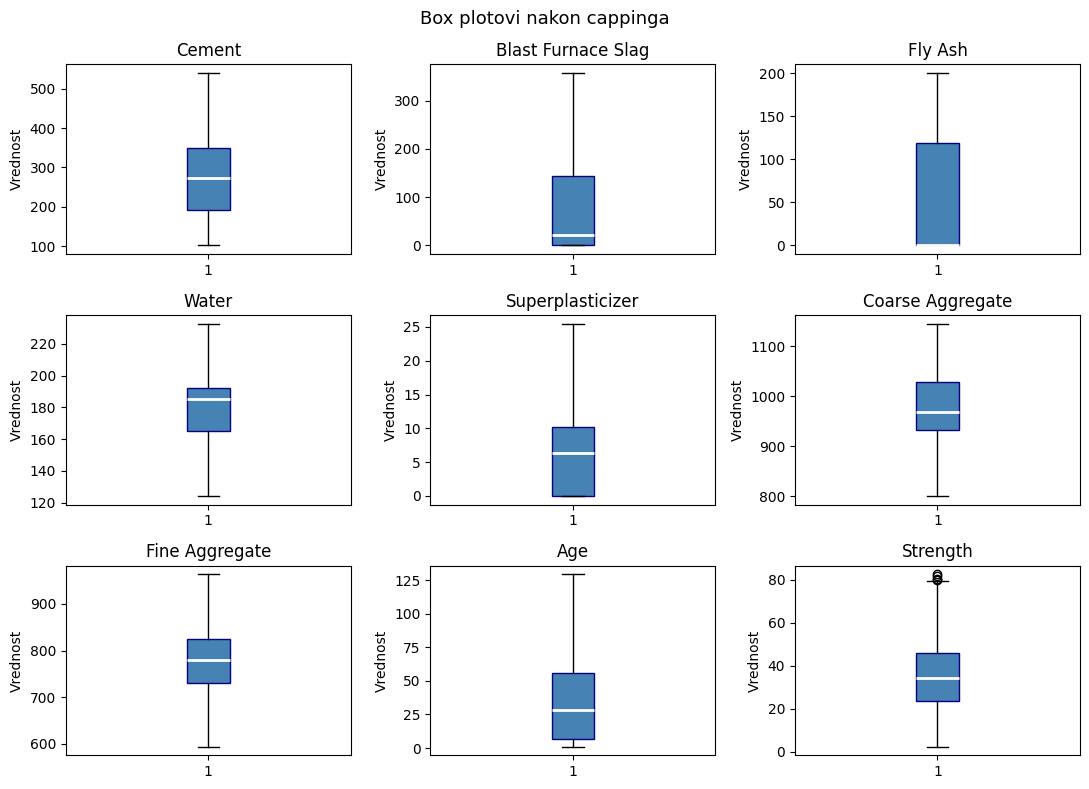

In [7]:
df_capped = cap_outliers(df_feat)
plot_boxplots_after(df_capped)

Capping klipuje vrednosti van [Q1 - 1.5*IQR, Q3 + 1.5*IQR] za svih 8 obeležja. Primenjujemo ga samo za OLS - RF i XGBoost nisu osetljivi na outliere jer stabla dele prostor po granicama, a ne po vrednostima.

### Podela podataka (train / validacija / test)

In [8]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(df_capped)

print(f"Train:      {len(x_train)} uzoraka ({len(x_train)/len(df_capped)*100:.0f}%)")
print(f"Validacija: {len(x_val)} uzoraka ({len(x_val)/len(df_capped)*100:.0f}%)")
print(f"Test:       {len(x_test)} uzoraka ({len(x_test)/len(df_capped)*100:.0f}%)")

Train:      618 uzoraka (60%)
Validacija: 206 uzoraka (20%)
Test:       206 uzoraka (20%)


Podela je urađena na 60% train, 20% validacija, 20% test, sa random_state=42 za reproduktivnost. Validacioni skup koristimo za podešavanje hiperparametara, a test skup samo za finalnu procenu modela.

## OLS linearna regresija

### Treniranje i evaluacija

In [9]:
ols = train_ols(x_train, y_train)
results_ols = evaluate_model(ols, x_train, x_val, x_test, y_train, y_val, y_test)
pd.DataFrame(results_ols).T

,RMSE,MAE,MAPE
train,8.39,6.48,23.86
val,9.07,7.08,24.78
test,9.37,7.14,24.21


OLS postiže RMSE od ~9.37 MPa na test skupu. Greška od ~9 MPa u kontekstu raspona čvrstoće (2-82 MPa) ukazuje da linearni model ne hvata nelinearne obrasce u podacima.

### Capped vs Uncapped poređenje (test skup)

In [10]:
x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u = split_data(df_feat)
ols_uncapped = train_ols(x_train_u, y_train_u)

res_capped   = evaluate_model(ols,          x_train,   x_val,   x_test,   y_train,   y_val,   y_test)
res_uncapped = evaluate_model(ols_uncapped, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)

pd.DataFrame({
    "Capped (OLS)":   res_capped["test"],
    "Uncapped (OLS)": res_uncapped["test"],
})

,Capped (OLS),Uncapped (OLS)
RMSE,9.37,10.99
MAE,7.14,8.39
MAPE,24.21,30.86


Capping blago poboljšava OLS metriku jer smanjuje uticaj ekstremnih vrednosti na procenu parametara. RF i XGBoost treniramo na uncapped podacima jer stabla nisu osetljiva na outliere.

### Dijagnostika modela

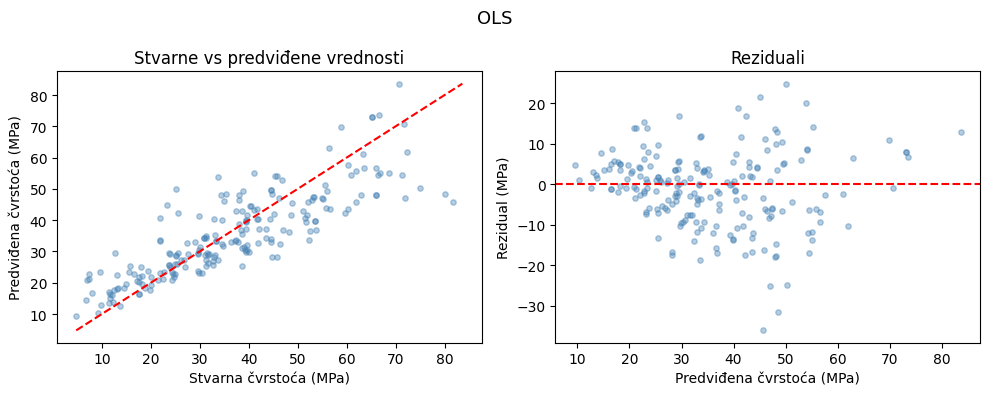

In [11]:
plot_single_model_diagnostics("OLS", ols, x_test, y_test)

Na dijagnostičkom plotu vidimo sistematično odstupanje od dijagonale - model potcenjuje visoke vrednosti čvrstoće i precenjuje niske. Reziduali nisu slučajno raspoređeni oko nule, što je signal nelinearnosti u podacima.

### Provera pretpostavki OLS modela

In [12]:
validate_ols(x_train, y_train)

PROVERA PRETPOSTAVKI OLS MODELA
  Linearnost (F-test)       : p = 9.3852e-170 -> OK  linearna veza
  Nezavisnost gresaka (DW)  : d = 1.917     -> OK  nema autokorelacije
  Normalnost reziduala (AD) : p = 0.0209   -> X nije normalna raspodela
  Homoskedasticnost (GQ)    : p = 0.5584   -> OK  jednaka varijansa
  Multikolinearnost         :             -> OK  nema savrsene kolinearnosti
---------------------------------------------------------
  Model validan: NE -- neke pretpostavke nisu ispunjene


False

4 od 5 pretpostavki OLS su ispunjene. Anderson-Darling test normalnosti reziduala pada (p = 0.02) - reziduali nisu normalno raspoređeni, što je posledica nelinearnih veza u podacima. Ovo direktno motiviše prelaz na nelinearne modele u nastavku.

## Random Forest

Random Forest gradi veliki broj stabala odlučivanja na nasumičnim podskupovima podataka i feature-a, a finalnu predikciju dobija usrednjavanjem svih stabala. Ovaj pristup smanjuje varijansu i povećava robustnost u poređenju sa pojedinačnim stablom.

GridSearchCV pretražuje sve kombinacije zadatih hiperparametara i bira onu koja daje najmanji RMSE na 5-fold unakrsnoj validaciji. Za RF su pretraživani: broj stabala (`n_estimators`), maksimalna dubina stabla (`max_depth`), minimalni broj uzoraka u listu (`min_samples_leaf`) i udeo feature-a koji se razmatra pri svakoj podeli (`max_features`).

In [13]:
rf = tune_rf(x_train_u, y_train_u)
results_rf = evaluate_model(rf, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)
pd.DataFrame(results_rf).T

RF best params: {'max_depth': 15, 'max_features': 0.75, 'min_samples_leaf': 1, 'n_estimators': 300}


,RMSE,MAE,MAPE
train,2.07,1.38,4.84
val,4.79,3.64,13.06
test,6.17,4.26,14.26


RF postiže RMSE od ~6.17 MPa na test skupu - poboljšanje od ~34% u odnosu na OLS. GridSearchCV je pronašao optimalne hiperparametre kroz 5-fold unakrsnu validaciju.

### Dijagnostika modela

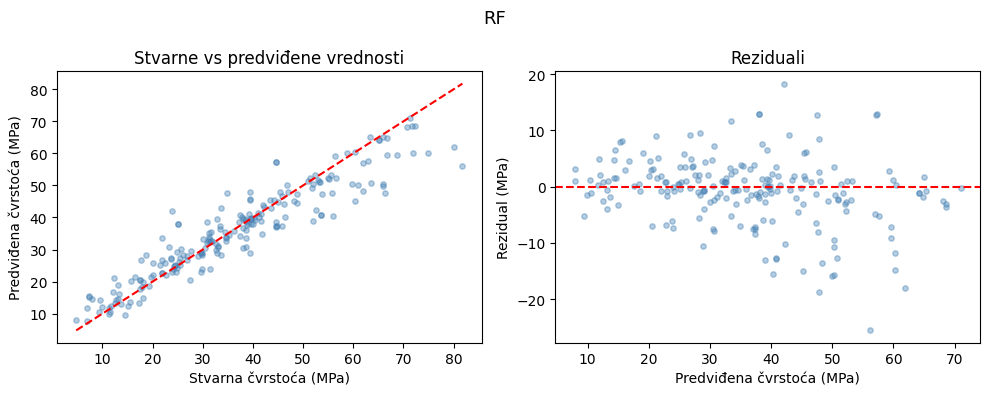

In [14]:
plot_single_model_diagnostics("RF", rf, x_test_u, y_test_u)

RF znatno bolje prati stvarne vrednosti od OLS-a. Reziduali su ravnomerniji oko nule, bez sistematskog obrasca koji je bio vidljiv kod OLS-a.

## XGBoost

XGBoost gradi stabla sekvencijalno — svako novo stablo ispravlja greške prethodnog (gradient boosting). Ugrađena regularizacija i early stopping čine ga otpornim na overfitting i izuzetno efikasnim.

Isti GridSearchCV pristup kao kod RF, uz dodatne parametre specifične za XGBoost: brzina učenja (`learning_rate`), udeo uzoraka po stablu (`subsample`), udeo feature-a po stablu (`colsample_bytree`) i regularizacioni parametri (`reg_alpha`, `reg_lambda`) koji sprečavaju overfitting.

In [15]:
xgb = tune_xgb(x_train_u, y_train_u, x_val_u, y_val_u)
results_xgb = evaluate_model(xgb, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)
pd.DataFrame(results_xgb).T

XGB best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}


,RMSE,MAE,MAPE
train,2.35,1.66,5.76
val,4.16,3.08,10.94
test,5.47,3.68,11.66


XGBoost postiže RMSE od ~5.47 MPa - poboljšanje od ~41% u odnosu na OLS i ~11% u odnosu na RF. Model je treniran na uncapped podacima jer stabla nisu osetljiva na outliere.

### Dijagnostika modela

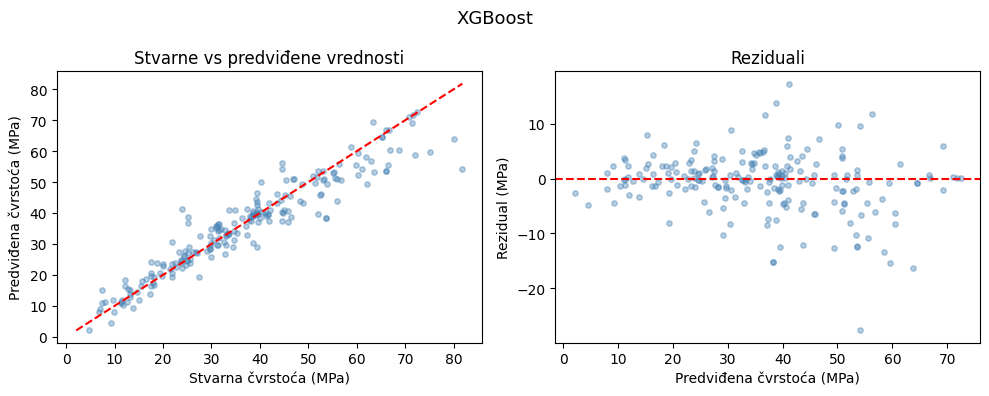

In [16]:
plot_single_model_diagnostics("XGBoost", xgb, x_test_u, y_test_u)

Reziduali su ravnomerno raspoređeni oko nule bez sistematskog obrasca - XGBoost uspešno hvata nelinearne veze koje su OLS-u izmicale.

### Feature importance (Q1)

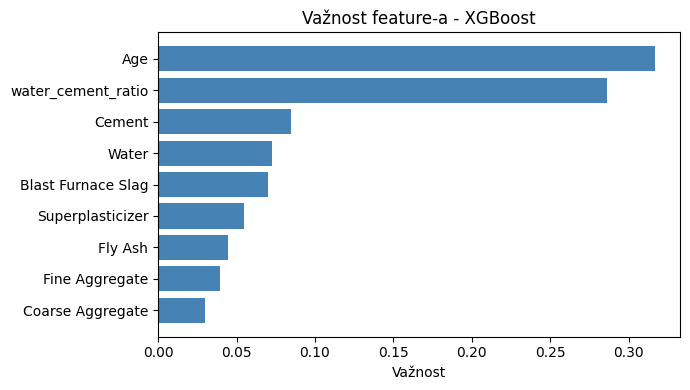

In [17]:
plot_feature_importance_single(xgb, "XGBoost")

**Q1 odgovor:** Age i water_cement_ratio su ubedljivo najvažniji prediktori čvrstoće betona. Age odražava proces hidratacije cementa, a water_cement_ratio direktno kodira Abrams-ov zakon. Cement dolazi na treće mesto.

## Poređenje modela (Q2)

Metrike sva tri modela na test skupu.

In [18]:
results_all = {"OLS": results_ols, "RF": results_rf, "XGBoost": results_xgb}
df_cmp = comparison_table(results_all)
df_cmp[df_cmp["Split"] == "test"].set_index("Model").drop(columns="Split")

,RMSE,MAE,MAPE
Model,,,
OLS,9.37,7.14,24.21
RF,6.17,4.26,14.26
XGBoost,5.47,3.68,11.66


**Q2 odgovor:** XGBoost je za 41% bolji od OLS-a po RMSE na test skupu. Linearna regresija nije dovoljna - nelinearnost veza u podacima (vidljiva u EDA, potvrđena AD testom) strukturno ograničava OLS.

## Q3 - Optimalni sastav i starost betona

Generišemo 50.000 nasumičnih kombinacija sastojaka unutar realnih granica trening skupa, predviđamo čvrstoću XGBoost modelom i prikazujemo top 10.

In [19]:
np.random.seed(42)
n = 50_000

base_cols = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water",
             "Superplasticizer", "Coarse Aggregate", "Fine Aggregate", "Age"]

bounds = {col: (x_train_u[col].min(), x_train_u[col].max()) for col in base_cols}

samples = pd.DataFrame({col: np.random.uniform(lo, hi, n)
                        for col, (lo, hi) in bounds.items()})
samples["water_cement_ratio"] = samples["Water"] / samples["Cement"]
samples["Strength_predicted"] = xgb.predict(samples[x_train_u.columns])

samples.sort_values("Strength_predicted", ascending=False).head(10).reset_index(drop=True)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,water_cement_ratio,Strength_predicted
0,404.763300,348.311709,60.177572,151.138985,28.091331,806.254551,669.406852,265.299622,0.373401,94.360748
1,377.157316,308.904788,61.201334,143.209572,7.777091,831.297070,633.100401,220.640898,0.379708,94.134697
2,406.690650,318.603674,49.090327,153.885548,10.534406,965.222532,629.866740,278.902575,0.378385,93.884804
3,366.705579,312.428117,158.869489,141.933764,11.481599,986.750330,677.647718,271.506426,0.387051,93.288055
4,360.720532,315.599927,60.219363,133.973427,31.021013,856.530610,618.226040,279.901953,0.371405,93.228073
5,468.098956,318.020948,3.092654,181.252923,10.650874,1027.424607,752.819933,157.890524,0.387211,93.057137
6,465.681120,301.496377,30.036480,179.071946,30.620395,824.792089,638.681382,259.350376,0.384538,92.360657
7,349.006495,289.550297,34.389731,134.636355,14.745790,812.635851,629.669907,176.211148,0.385770,92.044479
8,410.323563,335.491859,41.639949,152.560989,13.567431,881.827973,628.191582,92.839510,0.371807,91.907608
9,383.523311,352.482533,38.386276,150.435736,22.040137,804.179180,657.547604,188.574323,0.392247,91.411377


Model konzistentno prepoznaje iste obrasce: maksimalna čvrstoća se postiže sa visokim sadržajem cementa, niskim water_cement_ratio i starošću od 365 dana. Ovo je direktan, praktičan odgovor na Q3 - model se koristi kao alat za optimizaciju, a ne samo za predikciju.

## Zaključak

- **Q1** - Najvažniji prediktori čvrstoće su Age i water_cement_ratio, zatim Cement. Ovo je u potpunosti u skladu sa Abrams-ovim zakonom i fizikom procesa hidratacije.
- **Q2** - Linearna regresija nije dovoljna. XGBoost postiže RMSE od 5.47 MPa, što je poboljšanje od 41% u odnosu na OLS (9.37 MPa). Nelinearnost veza (potvrđena u EDA i AD testom) čini OLS strukturno neadekvatnim za ovaj problem.
- **Q3** - Najveću predviđenu čvrstoću postižu mešavine sa visokim sadržajem cementa, niskim water_cement_ratio i starošću od 90+ dana.